<a href="https://colab.research.google.com/github/franmazzaro/7506R-2C2023-GRUPO39/blob/main/7506R_TP2_GRUPO39_CHP1_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Librerias**

Empezamos importando las librerias que vamos a utilizar

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, make_scorer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Nadam

# Carga de datasets

In [ ]:
df_criticas = pd.read_csv('./content/sample_data/train.csv')
df_criticas_test = pd.read_csv('./content/sample_data/test.csv')

# Analisis Exploratorio

In [ ]:
df_criticas.head(4)

In [ ]:
# Resumen de datos
print("Resumen de datos:")
print(df_criticas.info())
print(df_criticas.describe())


Resumen de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB
None
                 ID
count  50000.000000
mean   24999.500000
std    14433.901067
min        0.000000
25%    12499.750000
50%    24999.500000
75%    37499.250000
max    49999.000000


In [ ]:
# Exploración de la variable objetivo (sentimiento)
print("\nCantidad de muestras por categoría:")
print(df_criticas['sentimiento'].value_counts())


Cantidad de muestras por categoría:
positivo    25000
negativo    25000
Name: sentimiento, dtype: int64


Vemos que hay la misma cantidad de reviews positivas y negativas.

In [ ]:
# Análisis de la variable 'review'
# Longitud de las reseñas
df_criticas_copy = df_criticas.copy()
df_criticas_copy['longitud_review'] = df_criticas_copy['review_es'].apply(lambda x: len(str(x)))
print("\nAnálisis de longitud de reseñas:")
print(df_criticas_copy.groupby('sentimiento')['longitud_review'].describe())


Análisis de longitud de reseñas:
               count        mean          std   min    25%     50%      75%  \
sentimiento                                                                   
negativo     25000.0  1382.77380   994.097890  39.0  755.0  1041.0  1685.00   
positivo     25000.0  1413.34268  1079.324047  64.0  738.0  1032.0  1733.25   

                 max  
sentimiento           
negativo      8587.0  
positivo     13465.0  


Podemos ver las metricas de las reviews segun la cantidad de caracteres.

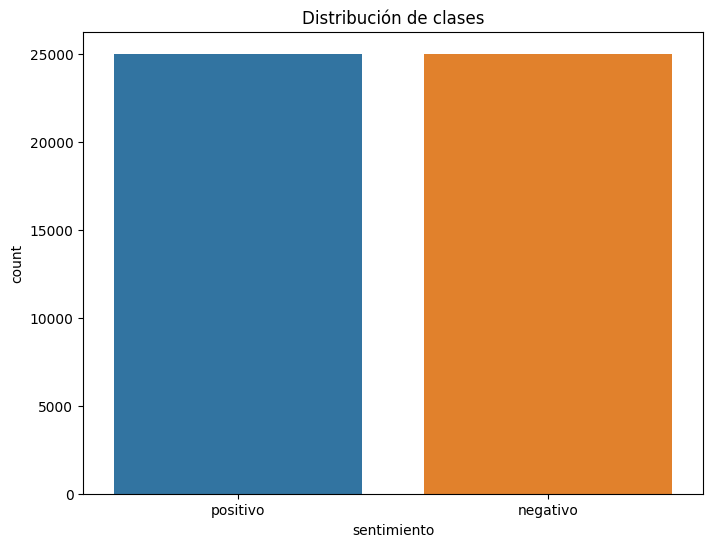

In [ ]:

# Visualización de datos
plt.figure(figsize=(8, 6))
sns.countplot(x='sentimiento', data=df_criticas)
plt.title('Distribución de clases')
plt.show()

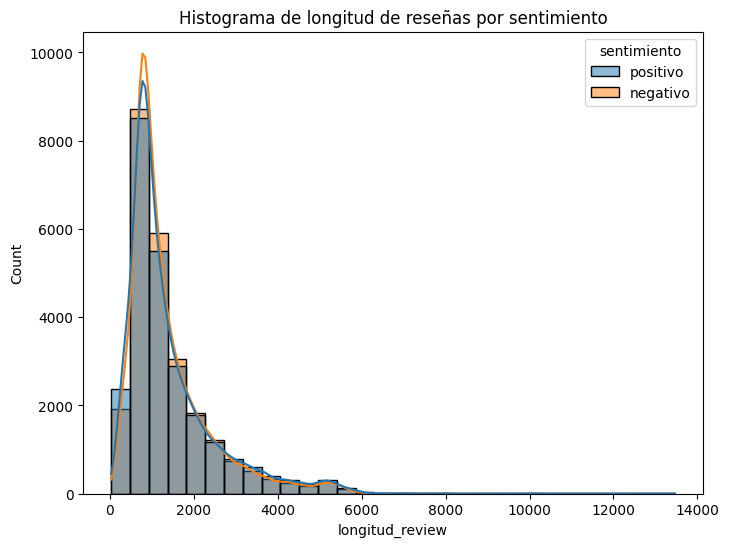

In [ ]:

plt.figure(figsize=(8, 6))
sns.histplot(data=df_criticas_copy, x='longitud_review', hue='sentimiento', bins=30, kde=True)
plt.title('Histograma de longitud de reseñas por sentimiento')
plt.show()

Podemos ver que la mayoria de las reseñas tienen entre 0 y 2000 caracteres.

# Preprocesamiento

Comenzamos el preprocesamiento vectorizando las reviews del dataset de train y test asi convertimos las criticas de texto a una representacion numerica.


Tambien hacemos lo mismo para transformar los sentimientos "positivo" y "negativo"

Dividimos nuestro dataset de train en 70% para entrenar y 30% para validar.


In [ ]:
# Vectorización de texto usando CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_criticas['review_es'])
X_test = vectorizer.transform(df_criticas_test['review_es'])

# Codificar las etiquetas de sentimiento
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_criticas['sentimiento'])

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=25)

In [ ]:
# Función para convertir valores
def convertir(valor):
    return "negativo" if valor == 0 else "positivo"

Esta funcion transforma de numerico a String el sentimiento

In [ ]:
def mostrar_metricas(y_test, y_pred):
  #Cantidad de aciertos
  print('correctas: ', np.sum(y_test == y_pred))
  print('total: ', len(y_test))

  print(classification_report(y_test, y_pred))

  #Grafico la matriz de confusión
  tabla=confusion_matrix(y_test, y_pred)
  sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()


# Bayes Naive

Dividimos nuestro conjunto de train en 70 30

In [ ]:
x_train_bayes, x_test_bayes, y_train_bayes, y_test_bayes = train_test_split(df_criticas.review_es,
                                                    df_criticas.sentimiento,
                                                    test_size=0.20,
                                                    random_state=25,
                                                    shuffle=True)

Antes de entrear un modelo para clasificacion necesitamos que este entrenamiento sea con valores numericos, y como nosotros tenemos palabras necesitamos convertirlas a vectores.

Utilizamos make_pipeline para aplicarle a nuestros modelos dos metodos distintos para vectorizar y luego el modelo de Naive Bayes Multidimensional. Una vez obtenidos los entrenamos

In [ ]:
model_NB = make_pipeline(TfidfVectorizer(), MultinomialNB())
model_NB_2 = make_pipeline(CountVectorizer(), MultinomialNB())

model_NB.fit(x_train_bayes, y_train_bayes)
model_NB_2.fit(x_train_bayes, y_train_bayes)

categorias_predichas = model_NB.predict(x_test_bayes)
categorias_predichas_2 = model_NB_2.predict(x_test_bayes)


correctas:  8528
total:  10000
              precision    recall  f1-score   support

    negativo       0.85      0.86      0.86      5093
    positivo       0.85      0.85      0.85      4907

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



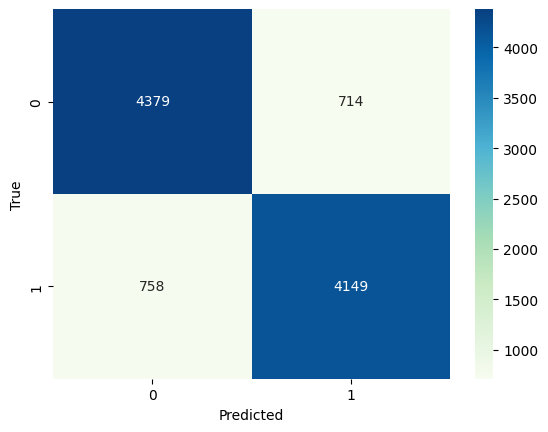

correctas:  8352
total:  10000
              precision    recall  f1-score   support

    negativo       0.81      0.88      0.84      5093
    positivo       0.86      0.79      0.82      4907

    accuracy                           0.84     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.84      0.83     10000



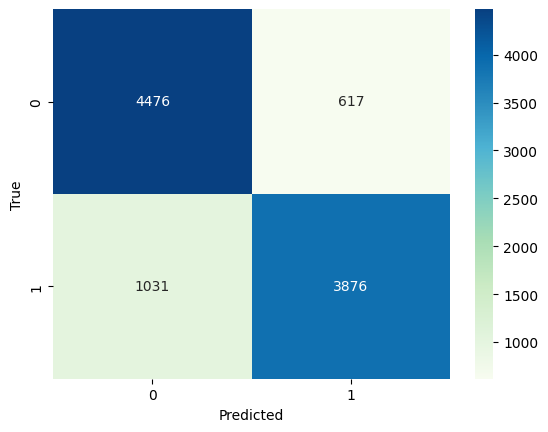

In [ ]:
mostrar_metricas(y_test_bayes, categorias_predichas)
mostrar_metricas(y_test_bayes, categorias_predichas_2)

Ya que el modelo 1 tuvo mejor accuracy es el que utilizamos para realizar la predicción de test

## Predicción sobre los datos de test

In [ ]:
criticas_test = df_criticas_test['review_es']
categorias_predichas_test = model_NB.predict(criticas_test)

Generamos el archivo de predicciones

In [ ]:
ids_test =  df_criticas_test.ID
filename = 'Naive_Bayes_Multidimensional'
prediccion = pd.DataFrame({"id": ids_test, "sentimiento": categorias_predichas_test})
prediccion.to_csv('/content/sample_data/prediccion_'+filename+'.csv', index = False)

# Random Forest

Optimizamos hiperparámetros

In [ ]:
tree = RandomForestClassifier(random_state=1)
params_grid = {
    'bootstrap': [True, False],
    'ccp_alpha': [0.0, 0.01, 0.02],
    'class_weight': [None, 'balanced'],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [10, 50, 100, 200],
}
rand = RandomizedSearchCV(tree, params_grid, cv=10, scoring='f1', n_iter=10, random_state=1)
rand.fit(x_train, y_train)
rand.cv_results_['mean_test_score']

array([0.66917622, 0.84101165, 0.76189623, 0.60415415, 0.79556803,
       0.68255784, 0.48244134, 0.67536519, 0.73080456, 0.69656625])

In [ ]:
rand.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 30,
 'criterion': 'gini',
 'class_weight': None,
 'ccp_alpha': 0.0,
 'bootstrap': True}

Usamos el mejor estimador para predecir sobre el conjunto de training y obtenemos sus métricas

correctas:  12476
total:  15000
              precision    recall  f1-score   support

           0       0.86      0.79      0.83      7599
           1       0.80      0.87      0.84      7401

    accuracy                           0.83     15000
   macro avg       0.83      0.83      0.83     15000
weighted avg       0.83      0.83      0.83     15000



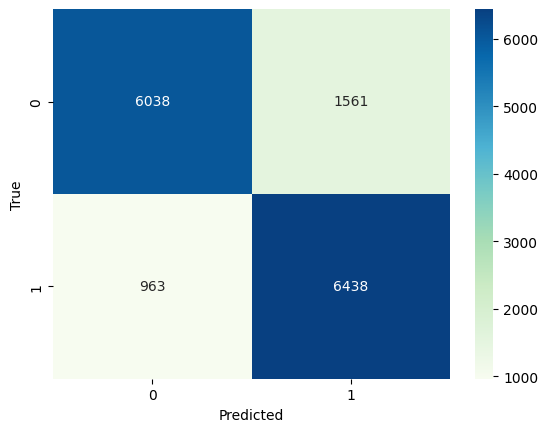

In [ ]:
opt_tree = rand.best_estimator_
y_pred = opt_tree.predict(x_test)
mostrar_metricas(y_test, y_pred)

## Predicción sobre los datos de test

In [ ]:
categorias_predichas_test = opt_tree.predict(X_test)

# Aplicar la función a cada elemento del array usando comprensión de listas
sentimientos = [convertir(valor) for valor in categorias_predichas_test]

In [ ]:
filename = 'Random_Forest_opt'
prediccion = pd.DataFrame({"id": df_criticas_test.ID, "sentimiento": sentimientos})
prediccion.to_csv('/content/sample_data/prediccion_'+filename+'.csv', index = False)

# XG Boost

Utilizamos un clasificador XGBoost para entrenar nuestro modelo

## XG Boost con parámetros default

In [ ]:
xg_boost_model = xgb.XGBClassifier(random_state=25, n_estimators=100)
xg_boost_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=25, ...)

In [ ]:
y_pred = xg_boost_model.predict(x_test)

correctas:  12561
total:  15000
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      7599
           1       0.82      0.86      0.84      7401

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



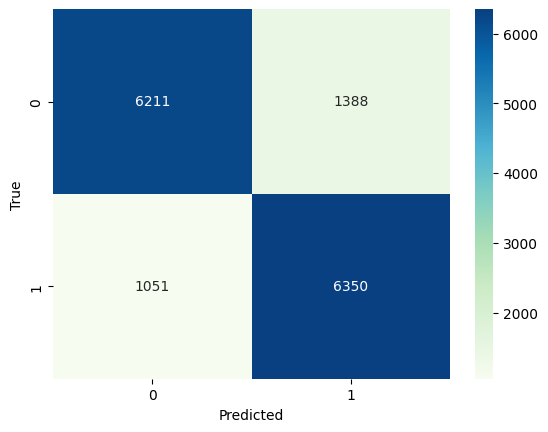

In [ ]:
mostrar_metricas(y_test, y_pred)

El modelo basico predice correctamente 12561 de 15000

## XG Boost con parámetros optimizados

In [ ]:
param_dist = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  # Tasa de aprendizaje
    'max_depth': [3, 4, 5, 6, 7, 8, 9],  # Profundidad máxima del árbol
    'min_child_weight': [1, 2, 3, 4],  # Mínimo peso de un niño (para evitar divisiones adicionales)
    'subsample': [0.8, 0.9, 1.0],  # Proporción de muestras utilizadas para entrenar árboles
    'colsample_bytree': [0.8, 0.9, 1.0],  # Proporción de características utilizadas para entrenar árboles
    'gamma': [0, 0.1, 0.2, 0.3],  # Parámetro de regularización para la poda
    'n_estimators': [100, 200, 300],  # Número de árboles (estimadores) en el bosque
}

# Inicializa el clasificador XGBoost
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=0)

# Realiza la búsqueda de hiperparámetros utilizando RandomizedSearchCV
n_iter = 10  # Número de combinaciones aleatorias a probar
xgb_search = RandomizedSearchCV(xgb_classifier, param_distributions=param_dist, n_iter=n_iter, scoring='f1', cv=5, random_state=0)

# Ajusta el modelo a los datos de entrenamiento
xgb_search.fit(x_train, y_train)

xgb_search.best_params_

{'subsample': 1.0,
 'n_estimators': 300,
 'min_child_weight': 4,
 'max_depth': 4,
 'learning_rate': 0.3,
 'gamma': 0,
 'colsample_bytree': 0.9}

Colocamos varios parametros para utilizar un RandomizedSearchCV y asi encontrar los mejores hiperparametros usando f1 como score ya que este se utiliza para medir en Kaggle y luego entrenamos el modelo

              precision    recall  f1-score   support

           0       0.87      0.84      0.86      7599
           1       0.84      0.87      0.86      7401

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000

correctas:  12844
total:  15000
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      7599
           1       0.84      0.87      0.86      7401

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



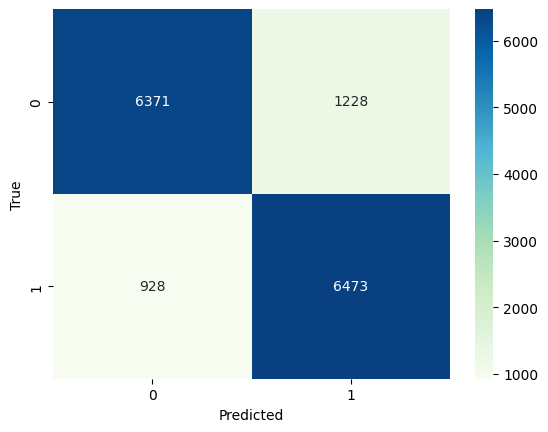

In [ ]:
opt_xg = xgb_search.best_estimator_
y_pred = opt_xg.predict(x_test)
print(classification_report(y_test, y_pred))
mostrar_metricas(y_test, y_pred)

Vemos que predice correctamente 12908 de 15000.

Predice 347 reviews mejor que el modelo default.

## Predicción sobre los datos de test

In [ ]:
categorias_predichas_test_xg = opt_xg.predict(X_test)

# Aplicar la función a cada elemento del array usando comprensión de listas
sentimientos = [convertir(valor) for valor in categorias_predichas_test_xg]

In [ ]:
filename = 'Xg_Boost_opt'
prediccion = pd.DataFrame({"id": df_criticas_test.ID, "sentimiento": sentimientos})
prediccion.to_csv('/content/sample_data/prediccion_'+filename+'.csv', index = False)

# Red neuronal (Keras Tensorflow)

## Modelo 1

Maxlen=1000

In [ ]:
# Tokenización y secuenciación de texto en los datos de entrenamiento
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_bayes)

X_train_seq = tokenizer.texts_to_sequences(x_train_bayes)  # Convertir texto a secuencias
X_test_seq = tokenizer.texts_to_sequences(x_test_bayes)

X_train_pad = pad_sequences(X_train_seq, maxlen=1000)  # Ajustar secuencias a una longitud máxima de 1000
X_test_pad = pad_sequences(X_test_seq, maxlen=1000)

encoder = LabelEncoder()
y_train_binario = encoder.fit_transform(y_train_bayes) # Enconding de la columna sentimiento
y_test_binario = encoder.transform(y_test_bayes)


In [ ]:
# Crear el modelo de red neuronal
model_1 = Sequential()
model_1.add(Embedding(len(tokenizer.word_index) + 1, 32, input_length=1000))  # Capa de embedding
model_1.add(Flatten())  # Aplanar la salida de la capa de embedding
model_1.add(Dense(16, activation='relu'))  # Capa densa con activación ReLU
model_1.add(Dense(1, activation='sigmoid'))  # Capa de salida con activación sigmoide para clasificación binaria


Embedding es una capa de procesamiento fundamental para el manejo de texto en redes neuronales. Esta capa se utiliza para convertir representaciones numéricas de palabras (índices enteros) en vectores densos de longitud fija.


El primer argumento, len(tokenizer.word_index) + 1, especifica el tamaño del vocabulario de entrada. tokenizer.word_index contiene un diccionario que asigna palabras a índices numéricos, y sumar 1 se hace porque generalmente se reserva un índice para palabras fuera del vocabulario o para el relleno.

El segundo argumento, 32, representa la dimensionalidad de los vectores de embedding. En este caso, cada palabra se representará mediante un vector de 32 dimensiones.


In [ ]:
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
model_1.fit(X_train_pad, y_train_binario, epochs=5, batch_size=32, validation_split=0.2)
y_pred = model_1.predict(X_test_pad)


Epoch 1/5
875/875 [==============================] - 114s 128ms/step - loss: 0.3813 - accuracy: 0.8251 - val_loss: 0.2848 - val_accuracy: 0.8827
Epoch 2/5
875/875 [==============================] - 100s 115ms/step - loss: 0.0721 - accuracy: 0.9785 - val_loss: 0.3273 - val_accuracy: 0.8733
Epoch 3/5
875/875 [==============================] - 100s 114ms/step - loss: 0.0068 - accuracy: 0.9993 - val_loss: 0.3954 - val_accuracy: 0.8726
Epoch 4/5
875/875 [==============================] - 126s 143ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.4239 - val_accuracy: 0.8756
Epoch 5/5
469/469 [==============================] - 3s 7ms/step


Definimos el optimizador, probamos usando adam y usamos loss = binary_crossentropy ya que estamos en un problema de clasificacion binario.

correctas:  13092
total:  15000
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      7599
           1       0.86      0.88      0.87      7401

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



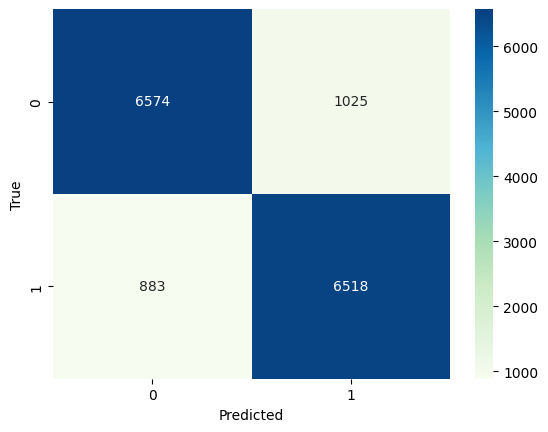

In [ ]:
threshold = 0.5
predicted_sentiments = [1 if pred > threshold else 0 for pred in y_pred]
mostrar_metricas(y_test_binario, predicted_sentiments)

Vemos que este modelo predijo correctamente 13092 de 15000 reviews

### Predicción sobre los datos de test

In [ ]:
# Preprocesamiento de los datos de prueba
X_test = df_criticas_test['review_es']  # Datos de texto de prueba
X_test_seq = tokenizer.texts_to_sequences(X_test)  # Convertir texto a secuencias para datos de prueba
X_test_pad = pad_sequences(X_test_seq, maxlen=1000)  # Ajustar secuencias a una longitud máxima de 1000 para datos de prueba

# Predicción en el conjunto de prueba
predictions = model_1.predict(X_test_pad)

# Ajustar un umbral para determinar las clases basadas en las probabilidades
threshold = 0.5
predicted_sentiments = ['positivo' if pred > threshold else 'negativo' for pred in predictions]

In [ ]:
filename = 'tensorflow_2'
prediccion = pd.DataFrame({"id": df_criticas_test.ID, "sentimiento": predicted_sentiments})
prediccion.to_csv('/content/sample_data/prediccion_'+filename+'.csv', index = False)

Este modelo nos dio un score de 0.74336 en Kaggle, nuestra mejor predicción

## Modelo 2

Maxlen=1500

learning_rate=0.001

optimizer=Nadam

Ahora probamos extender la longitud de las secuencias a 1500 caracteres y aplicamos learning_rate para reducir el overfitting

In [ ]:
# Tokenización y secuenciación de texto en los datos de entrenamiento
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_bayes)

X_train_seq = tokenizer.texts_to_sequences(x_train_bayes)  # Convertir texto a secuencias
X_test_seq = tokenizer.texts_to_sequences(x_test_bayes)

X_train_pad = pad_sequences(X_train_seq, maxlen=1500)  # Ajustar secuencias a una longitud máxima de 1500
X_test_pad = pad_sequences(X_test_seq, maxlen=1500)

encoder = LabelEncoder()
y_train_binario = encoder.fit_transform(y_train_bayes) # Enconding de la columna sentimiento
y_test_binario = encoder.transform(y_test_bayes)

Por lo tanto, aumentamos el parámetro input_length a 1500

In [ ]:
# Crear el modelo de red neuronal
model_2 = Sequential()
model_2.add(Embedding(len(tokenizer.word_index) + 1, 32, input_length=1500))  # Capa de embedding
model_2.add(Flatten())  # Aplanar la salida de la capa de embedding
model_2.add(Dense(16, activation='relu'))  # Capa densa con activación ReLU
model_2.add(Dense(1, activation='sigmoid'))  # Capa de salida con activación sigmoide para clasificación binaria

In [ ]:
model_2.compile(optimizer=Nadam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
model_2.fit(X_train_pad, y_train_binario, epochs=5, batch_size=32, validation_split=0.2)
y_pred = model_2.predict(X_test_pad)


Epoch 1/5
875/875 [==============================] - 141s 155ms/step - loss: 0.6938 - accuracy: 0.5050 - val_loss: 0.6937 - val_accuracy: 0.4860
Epoch 2/5
875/875 [==============================] - 132s 151ms/step - loss: 0.6928 - accuracy: 0.5073 - val_loss: 0.6936 - val_accuracy: 0.4861
Epoch 3/5
875/875 [==============================] - 130s 149ms/step - loss: 0.4267 - accuracy: 0.7746 - val_loss: 0.3007 - val_accuracy: 0.8753
Epoch 4/5
875/875 [==============================] - 131s 150ms/step - loss: 0.0885 - accuracy: 0.9707 - val_loss: 0.3363 - val_accuracy: 0.8710
Epoch 5/5
469/469 [==============================] - 3s 6ms/step


correctas:  13085
total:  15000
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      7599
           1       0.89      0.85      0.87      7401

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



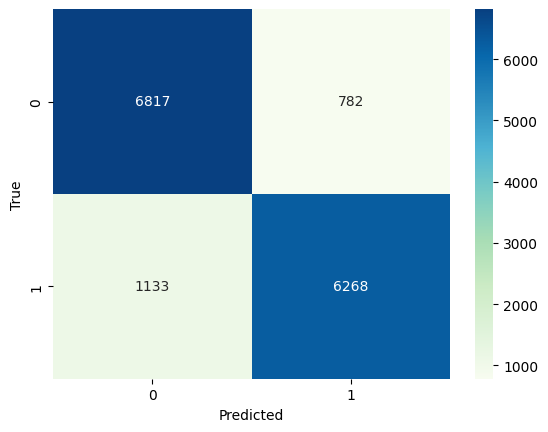

In [ ]:
threshold = 0.5
predicted_sentiments = [1 if pred > threshold else 0 for pred in y_pred]
mostrar_metricas(y_test_binario, predicted_sentiments)

Este modelo predijo correctamente 13085 reviews, lo cual es apenas un poco peor que nuestro modelo anterior, con una diferencia de 7 reviews.
Sin embargo esperamos que el learning rate haya logrado aumentar el score de la predicción en Kaggle

### Predicción sobre los datos de test

In [ ]:
# Preprocesamiento de los datos de prueba
X_test = df_criticas_test['review_es']  # Datos de texto de prueba
X_test_seq = tokenizer.texts_to_sequences(X_test)  # Convertir texto a secuencias para datos de prueba
X_test_pad = pad_sequences(X_test_seq, maxlen=1500)  # Ajustar secuencias a una longitud máxima de 1500 para datos de prueba

# Predicción en el conjunto de prueba
predictions = model_2.predict(X_test_pad)

# Ajustar un umbral para determinar las clases basadas en las probabilidades
threshold = 0.5
predicted_sentiments = ['positivo' if pred > threshold else 'negativo' for pred in predictions]

269/269 [==============================] - 2s 6ms/step


In [ ]:
filename = 'tensorflow_4'
prediccion = pd.DataFrame({"id": df_criticas_test.ID, "sentimiento": predicted_sentiments})
prediccion.to_csv('/content/sample_data/prediccion_'+filename+'.csv', index = False)

Con un score de 0.72824 podemos confirmar que este modelo tuvo peor desempeño que el anterior, por lo que continuaremos optimizando el modelo 1

## Modelo 1 con más épocas

In [ ]:
# Tokenización y secuenciación de texto en los datos de entrenamiento
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_bayes)

X_train_seq = tokenizer.texts_to_sequences(x_train_bayes)  # Convertir texto a secuencias
X_test_seq = tokenizer.texts_to_sequences(x_test_bayes)

X_train_pad = pad_sequences(X_train_seq, maxlen=1500)  # Ajustar secuencias a una longitud máxima de 1500
X_test_pad = pad_sequences(X_test_seq, maxlen=1500)

encoder = LabelEncoder()
y_train_binario = encoder.fit_transform(y_train_bayes) # Enconding de la columna sentimiento
y_test_binario = encoder.transform(y_test_bayes)


In [ ]:
# Crear el modelo de red neuronal
model_3 = Sequential()
model_3.add(Embedding(len(tokenizer.word_index) + 1, 32, input_length=1000))  # Capa de embedding
model_3.add(Flatten())  # Aplanar la salida de la capa de embedding
model_3.add(Dense(16, activation='relu'))  # Capa densa con activación ReLU
model_3.add(Dense(1, activation='sigmoid'))  # Capa de salida con activación sigmoide para clasificación binaria


In [ ]:
model_3.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
model_3.fit(X_train_pad, y_train_binario, epochs=50, batch_size=32, validation_split=0.2)
y_pred = model_3.predict(X_test_pad)

Epoch 1/50


1000/1000 [==============================] - 83s 82ms/step - loss: 0.6933 - accuracy: 0.5035 - val_loss: 0.6940 - val_accuracy: 0.4839
Epoch 2/50
1000/1000 [==============================] - 80s 80ms/step - loss: 0.6903 - accuracy: 0.5094 - val_loss: 0.6958 - val_accuracy: 0.4854
Epoch 3/50
1000/1000 [==============================] - 77s 77ms/step - loss: 0.4306 - accuracy: 0.7667 - val_loss: 0.2956 - val_accuracy: 0.8761
Epoch 4/50
1000/1000 [==============================] - 78s 78ms/step - loss: 0.0997 - accuracy: 0.9647 - val_loss: 0.3297 - val_accuracy: 0.8704
Epoch 5/50
1000/1000 [==============================] - 78s 78ms/step - loss: 0.0075 - accuracy: 0.9987 - val_loss: 0.4420 - val_accuracy: 0.8635
Epoch 6/50
1000/1000 [==============================] - 78s 78ms/step - loss: 0.0010 - accuracy: 0.9999 - val_loss: 0.4879 - val_accuracy: 0.8650
Epoch 7/50
1000/1000 [==============================] - 77s 77ms/step - loss: 2.3028e-04 - accuracy: 1.0000 - val_loss: 0.

correctas:  8531
total:  10000
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      5093
           1       0.85      0.85      0.85      4907

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



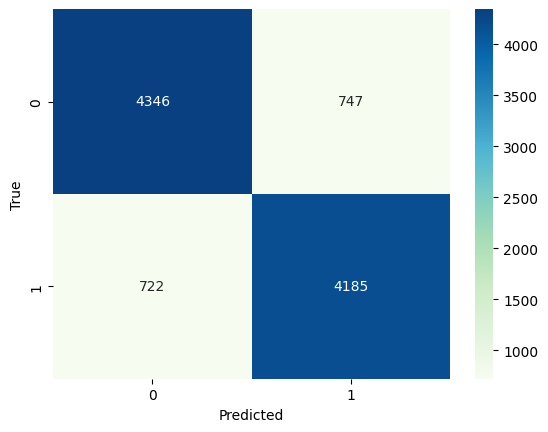

In [ ]:
threshold = 0.5
predicted_sentiments = [1 if pred > threshold else 0 for pred in y_pred]
mostrar_metricas(y_test_binario, predicted_sentiments)

### Predicción sobre los datos de test

In [ ]:
# Preprocesamiento de los datos de prueba
X_test = df_criticas_test['review_es']  # Datos de texto de prueba
X_test_seq = tokenizer.texts_to_sequences(X_test)  # Convertir texto a secuencias para datos de prueba
X_test_pad = pad_sequences(X_test_seq, maxlen=1000)  # Ajustar secuencias a una longitud máxima de 1500 para datos de prueba

# Predicción en el conjunto de prueba
predictions = model_3.predict(X_test_pad)

# Ajustar un umbral para determinar las clases basadas en las probabilidades
threshold = 0.5
predicted_sentiments = ['positivo' if pred > threshold else 'negativo' for pred in predictions]

269/269 [==============================] - 1s 3ms/step


In [ ]:
filename = 'tensorflow_6'
prediccion = pd.DataFrame({"id": df_criticas_test.ID, "sentimiento": predicted_sentiments})
prediccion.to_csv('./content/sample_data/prediccion_'+filename+'.csv', index = False)

## Modelo 2 con más épocas

In [ ]:
# Tokenización y secuenciación de texto en los datos de entrenamiento
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_bayes)

X_train_seq = tokenizer.texts_to_sequences(x_train_bayes)  # Convertir texto a secuencias
X_test_seq = tokenizer.texts_to_sequences(x_test_bayes)

X_train_pad = pad_sequences(X_train_seq, maxlen=1500)  # Ajustar secuencias a una longitud máxima de 1500
X_test_pad = pad_sequences(X_test_seq, maxlen=1500)

encoder = LabelEncoder()
y_train_binario = encoder.fit_transform(y_train_bayes) # Enconding de la columna sentimiento
y_test_binario = encoder.transform(y_test_bayes)


In [ ]:
# Crear el modelo de red neuronal
model_4 = Sequential()
model_4.add(Embedding(len(tokenizer.word_index) + 1, 32, input_length=1500))  # Capa de embedding
model_4.add(Flatten())  # Aplanar la salida de la capa de embedding
model_4.add(Dense(16, activation='relu'))  # Capa densa con activación ReLU
model_4.add(Dense(1, activation='sigmoid'))  # Capa de salida con activación sigmoide para clasificación binaria


In [ ]:
model_4.compile(optimizer=Nadam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
model_4.fit(X_train_pad, y_train_binario, epochs=50, batch_size=32, validation_split=0.2)
y_pred = model_4.predict(X_test_pad)

Epoch 1/50


1000/1000 [==============================] - 112s 111ms/step - loss: 0.3811 - accuracy: 0.8149 - val_loss: 0.2881 - val_accuracy: 0.8798
Epoch 2/50
1000/1000 [==============================] - 109s 109ms/step - loss: 0.0920 - accuracy: 0.9702 - val_loss: 0.3247 - val_accuracy: 0.8786
Epoch 3/50
1000/1000 [==============================] - 110s 110ms/step - loss: 0.0103 - accuracy: 0.9984 - val_loss: 0.3851 - val_accuracy: 0.8759
Epoch 4/50
1000/1000 [==============================] - 108s 108ms/step - loss: 0.0017 - accuracy: 0.9999 - val_loss: 0.4426 - val_accuracy: 0.8715
Epoch 5/50
1000/1000 [==============================] - 113s 112ms/step - loss: 3.6134e-04 - accuracy: 1.0000 - val_loss: 0.4638 - val_accuracy: 0.8751
Epoch 6/50
1000/1000 [==============================] - 116s 116ms/step - loss: 1.5449e-04 - accuracy: 1.0000 - val_loss: 0.4931 - val_accuracy: 0.8742
Epoch 7/50
1000/1000 [==============================] - 116s 116ms/step - loss: 7.5973e-05 - accuracy:

correctas:  8805
total:  10000
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      5093
           1       0.89      0.87      0.88      4907

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



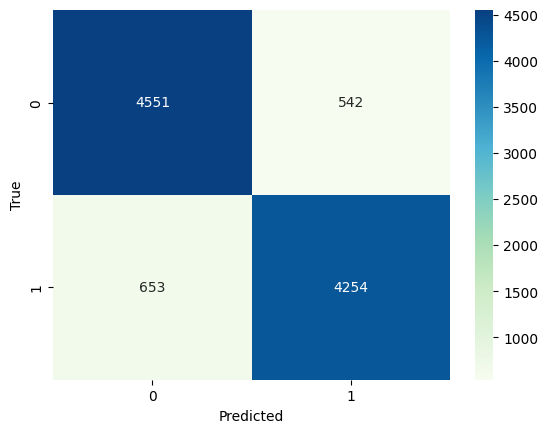

In [ ]:
threshold = 0.5
predicted_sentiments = [1 if pred > threshold else 0 for pred in y_pred]
mostrar_metricas(y_test_binario, predicted_sentiments)

Accuracy con 50 épocas:

Modelo 1: 0.85

Modelo 2: 0.88

### Predicción sobre los datos de test

In [ ]:
# Preprocesamiento de los datos de prueba
X_test = df_criticas_test['review_es']  # Datos de texto de prueba
X_test_seq = tokenizer.texts_to_sequences(X_test)  # Convertir texto a secuencias para datos de prueba
X_test_pad = pad_sequences(X_test_seq, maxlen=1000)  # Ajustar secuencias a una longitud máxima de 1500 para datos de prueba

# Predicción en el conjunto de prueba
predictions = model_3.predict(X_test_pad)

# Ajustar un umbral para determinar las clases basadas en las probabilidades
threshold = 0.5
predicted_sentiments = ['positivo' if pred > threshold else 'negativo' for pred in predictions]

269/269 [==============================] - 1s 3ms/step


In [ ]:
filename = 'tensorflow_5'
prediccion = pd.DataFrame({"id": df_criticas_test.ID, "sentimiento": predicted_sentiments})
prediccion.to_csv('./content/sample_data/prediccion_'+filename+'.csv', index = False)

## Conclusiones

Entonces, para el modelo 1 (max length 1000 y sin learning rate) Kaggle da: 0.74336.

Si le agregamos 50 épocas vemos que empeora y el score pasa a ser: 0.71176

En cambio, el modelo 2 (max length 1500 y learning rate 0.001) en Kaggle da: 0.72824

Y si lo entrenamos con 50 épocas vemos que mejora y obtenemos un score de 0.73657

Por lo que podemos concluir que en algunos casos aumentar las épocas resulta favorecedor y en otros no, independientemente del score de train.

# Ensamble (Voting)

Al crear el ensamble utilizando el modelo de red neuronal tuvimos muchos inconvenientes ya que resultó no ser un estimador compatible con scikit-learn. Por lo que decidimos entrenar un SVM con kernel polinómico como nuestro tercer modelo. De esa forma, nos quedamos con Random Forest, XG Boost y SVM como nuestros estimadores del ensamble

## SVM Polinómico

[0.86583606 0.79729415 0.87935015 0.86369912 0.87935015]
{'kernel': 'poly', 'gamma': 0.001, 'degree': 1, 'coef0': 0.1, 'C': 10}
0.87935014624742
correctas:  10173
total:  15000
              precision    recall  f1-score   support

           0       0.66      0.74      0.70      7599
           1       0.70      0.62      0.65      7401

    accuracy                           0.68     15000
   macro avg       0.68      0.68      0.68     15000
weighted avg       0.68      0.68      0.68     15000



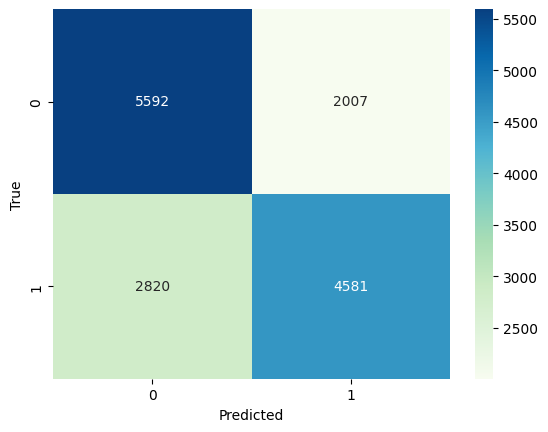

In [ ]:
params_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['poly'],
    'gamma': [0.1, 0.01, 0.001],
    'degree': [1, 2],
    'coef0': [0.0, 0.1, 0.5]
    }

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=5)

#Clasificador
svm = SVC()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#RandomizedSearch CV
randomcv = RandomizedSearchCV(estimator=svm,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=5,
                              random_state=1)
randomcv.fit(x_train,y_train)

print(randomcv.cv_results_['mean_test_score'])
#Mejores hiperparametros
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)
#Mejor estimador
best_svm_poly = randomcv.best_estimator_
#Predicción con mejor estimador
y_pred=best_knn.predict(x_test)


mostrar_metricas(y_test, y_pred)

No se debe tener en cuenta el gráfico de arriba ya que fue generado a partir de un modelo que decidimos no usar (best_knn), pero no pudimos repetir la ejecución de la celda ya que toma casi 15 horas.
Sin embargo, en el resto del trabajo continuamos usando el modelo correcto (best_svm_poly)

correctas:  13196
total:  15000
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      7599
           1       0.87      0.89      0.88      7401

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



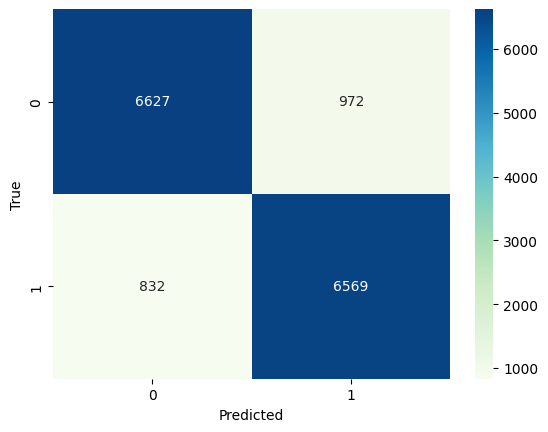

In [ ]:
y_pred=best_svm_poly.predict(x_test)

mostrar_metricas(y_test, y_pred)

Nuestro modelo de SVM logró predecir correctamente 13196 reviews, lo que lo coloca como nuestro mejor modelo sin contar redes neuronales

### Predicción sobre los datos de test

In [ ]:
predicted = best_svm_poly.predict(X_test)
predicted_sentiments = [convertir(valor) for valor in predicted]

filename = 'svm_poly'
prediccion = pd.DataFrame({"id": df_criticas_test.ID, "sentimiento": predicted_sentiments})
prediccion.to_csv('./content/sample_data/prediccion_'+filename+'.csv', index = False)

Al subir la predicción a Kaggle, obtuvo un score de 0.73347, colocándose como nuestro mejor modelo después de las redes neuronales

## Creamos el ensamble

correctas:  13049
total:  15000
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      7599
           1       0.85      0.89      0.87      7401

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



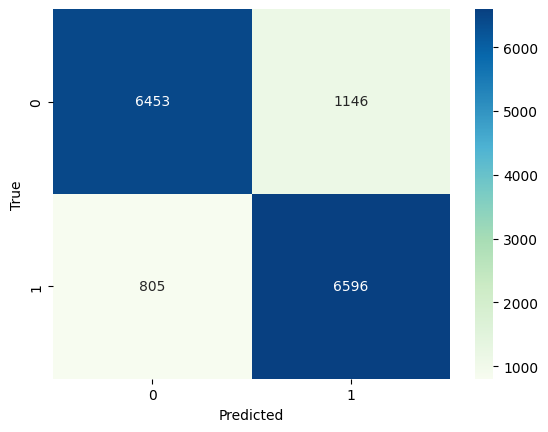

In [ ]:
vot_clf = VotingClassifier(estimators = [ ('xg_boost', opt_xg), ('random_forest', opt_tree), ('svm', best_svm_poly)], voting = 'hard')

#Entreno el ensemble
vot_clf.fit(x_train, y_train)

#Evaluo en conjunto de test
pred = vot_clf.predict(x_test)

mostrar_metricas(y_test, pred)

Nuestro ensamble logró predecir correctamente 13049 de 15000 reviews, mientras que los modelos que lo integran, obtuvieron las siguientes reviews correctas:

XG Boost: 12908

Random Forest: 12476

SVM: 13196

In [ ]:
predicted_sentiments = vot_clf.predict(X_test)
predicted_sentiments = [convertir(valor) for valor in predicted_sentiments]
filename = 'voting'
prediccion = pd.DataFrame({"id": df_criticas_test.ID, "sentimiento": predicted_sentiments})
prediccion.to_csv('./content/sample_data/prediccion_'+filename+'.csv', index = False)

Finalmente, en Kaggle, el ensamble obtuvo un score de 0.73657, llegando a alcanzar a nuestro segundo mejor modelo (modelo 2 de redes neuronales con 50 épocas)